**From a series of application of modern interpolation methods for economics: written by [Mahdi E Kahou](https://sites.google.com/site/mahdiebrahimikahou/about-me)**


# Goal of this notebook  
The goal of this notebook is to demonstrate:  
1. How to calculate the derivative of a neural network with respect to its input.  
2. How to minimize a loss function that explicitly involves the derivative of a neural network.  

---

## The Mathematical Application

Consider the following ordinary differential equation:  

$$
\begin{align}
\dot{y} + y &= 0, \\
y(0) &= y_0.
\end{align}
$$  

This ODE admits a simple closed-form solution:  

$$
y(t) = y_0 e^{-t}.
$$

Suppose we want to solve this problem using a neural network, denoted by $\hat{y}(t)$.  

---

## Challenge: Computing Input Derivatives  
To solve the ODE, we need to compute the derivative of the neural network with respect to its input:  

$$
\dot{\hat{y}}(t) = \frac{d \hat{y}(t)}{dt}.
$$  

Python packages like `PyTorch` readily provide derivatives of the neural network with respect to its **weights and biases**, but they do not automatically provide derivatives with respect to the **input**.  

---

## Loss Function  

Using this derivative, we can minimize the following loss function:

$$
\begin{align}
\mathcal{L} = \frac{1}{n} \sum_{t_i \in \mathcal{D}} 
\Big( \left[\dot{\hat{y}}(t_i) + \hat{y}(t_i)\right]^2 
+ \left[\hat{y}(0) - y_0\right]^2 \Big),
\end{align}
$$
 
where  

$$
\mathcal{D} \equiv \{t_1,\cdots,t_n\}.
$$


In [1]:
# Importing packages

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
# setting the initial condition

In [4]:
y_0 = 1 

In [5]:
# defining the neural network

In [6]:
class NN(nn.Module):
    def __init__(self,
                 dim_hidden = 128,
                layers = 4,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias

        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.Tanh())

        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.Tanh())

        module.append(nn.Linear(self.dim_hidden,1))
        module.append(nn.Softplus(beta = 1.0)) #The softplus layer ensures c>0,k>0

        self.q = nn.Sequential(*module)


    def forward(self, x):
        out = self.q(x) # first element is consumption, the second element is capital
        return  out

In [7]:
# defining the training data

In [8]:
train_t_max = 29
time_grid = torch.arange(0.0, train_t_max , 0.5)
time_grid = time_grid.unsqueeze(dim =1)

data_loader = DataLoader(time_grid, batch_size=len(time_grid), shuffle= False)

Taking the derivative with respect to the input: an example before the training loop

To achieve this, we use PyTorch’s `autograd` functionality.

-----------------------


In [9]:
net = NN()

# Input (requires_grad=True so we can differentiate wrt input)
t = torch.tensor([[1.0]], requires_grad=True)

# Forward pass
y = net(t)

# Compute dy/dx using autograd
dydt = torch.autograd.grad(
    outputs=y, 
    inputs=t,
    grad_outputs=torch.ones_like(y),  # vector-Jacobian product
    create_graph=True  # keep graph if you want higher-order derivatives
)[0]


In [10]:
print("y(t) =", y.item())
print("dy/dt =", dydt.item())

y(t) = 0.7231759428977966
dy/dt = 0.006894356105476618


--------------

In [11]:
# definining the derivative function

In [12]:
def dy_dt(t, model):
   
    t = t.clone().detach().float()

    # Ensure correct shape and enable gradient tracking
    t = t.view(-1, 1).requires_grad_(True)

    y = model(t)  # forward pass
    dy = torch.autograd.grad(
        outputs=y,
        inputs=t,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

    return dy

In [13]:
# setting up the optimizer

In [14]:
y_hat = NN()
learning_rate = 1e-3
optimizer = torch.optim.Adam(y_hat.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

In [15]:
# number of epochs

In [16]:
num_epochs = 2001

print_epoch_frequency = 100 # how often printing the results

In [17]:
# Training loop

for epoch in range(num_epochs):
    for time in data_loader:
        optimizer.zero_grad() # Resetting the gradients (with respect to NN coefficients)
        
        y = y_hat(time)
        dydt = dy_dt(time,y_hat)
        
        residual_ode = y+ dydt
        
        time_zero = torch.zeros([1,1]) # t = 0 
        residual_initial_cond = y_hat(time_zero)-y_0
        loss = residual_ode.pow(2).mean() + residual_initial_cond.pow(2).mean()
        
        loss.backward() # Calculating the gradients (with respect to NN coefficients)
        optimizer.step() # Using the gradients to minimize the loss function
        
    scheduler.step() # Dampening the learning rate
    
    if epoch % print_epoch_frequency == 0:
        print(f"epoch = {epoch}, loss = {loss.detach().numpy():.2e}")




epoch = 0, loss = 6.28e-01
epoch = 100, loss = 1.28e-03
epoch = 200, loss = 2.99e-04
epoch = 300, loss = 1.36e-04
epoch = 400, loss = 9.54e-05
epoch = 500, loss = 8.54e-05
epoch = 600, loss = 6.34e-05
epoch = 700, loss = 1.07e-04
epoch = 800, loss = 5.55e-05
epoch = 900, loss = 4.34e-05
epoch = 1000, loss = 3.52e-05
epoch = 1100, loss = 2.93e-05
epoch = 1200, loss = 3.94e-05
epoch = 1300, loss = 2.74e-05
epoch = 1400, loss = 2.34e-05
epoch = 1500, loss = 2.03e-05
epoch = 1600, loss = 1.88e-03
epoch = 1700, loss = 1.99e-05
epoch = 1800, loss = 1.75e-05
epoch = 1900, loss = 1.56e-05
epoch = 2000, loss = 1.41e-05


### Plotting the results

In [25]:
# closed-form solution

In [76]:
fontsize= 14
ticksize = 14
figsize = (14, 6)
params = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params)

In [77]:
def y_cf(t):
    return y_0*torch.exp(-t)

In [78]:
test_T = 50
time_grid_test = torch.arange(0.0, test_T , 0.25)
time_grid_test = time_grid_test.unsqueeze(dim =1)

In [79]:
# Closed-form solution
def y_cf(t):
    return y_0 * torch.exp(-t)

# Evaluate solution
y_closed_form = y_cf(time_grid_test)


In [80]:
y_hat_test = y_hat(time_grid_test).detach() # \hat{y}(t)

In [81]:
# relative errors
errors = torch.abs(y_hat_test - y_closed_form)

In [82]:
# interpolation boundary:
T_interpolation =  time_grid.max().item()

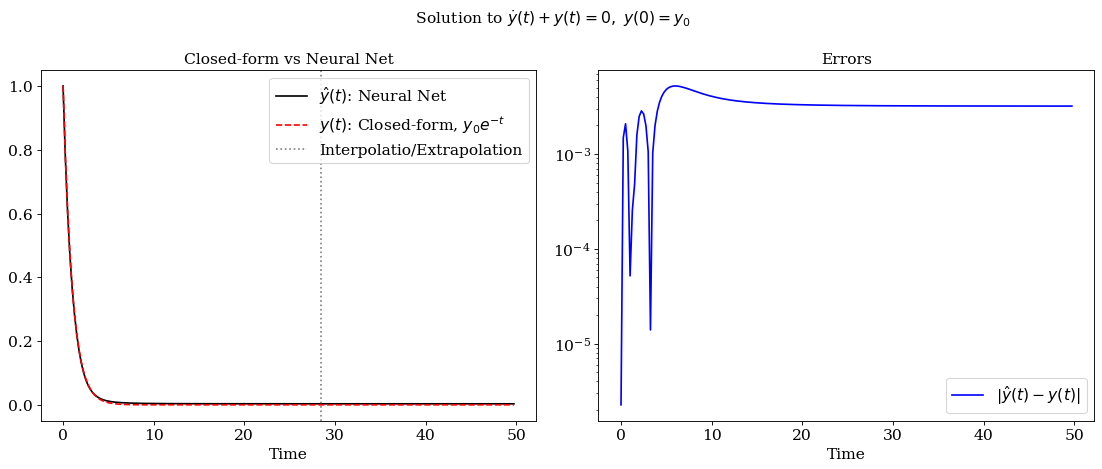

In [86]:
fig, axes = plt.subplots(1, 2)

# --- Left plot ---
axes[0].plot(time_grid_test, y_hat_test, label=r"$\hat{y}(t)$: Neural Net", color="k")
axes[0].plot(time_grid_test, y_closed_form, 
             label=r"$y(t)$: Closed-form, $y_0 e^{-t}$", 
             color="red", linestyle="dashed")
axes[0].axvline(x=T_interpolation, color="gray", linestyle="dotted", label=r"Interpolatio/Extrapolation")  # 👈 horizontal line
axes[0].set_xlabel("Time")
axes[0].set_title(r"Closed-form vs Neural Net")
axes[0].legend(loc="upper right")

# --- Right plot (residuals example, you can change what you want here) ---
residuals = y_hat_test - y_closed_form
axes[1].plot(time_grid_test, errors, color="blue", label = r"|$\hat{y}(t) - y(t)|$")
axes[1].set_xlabel("Time")
axes[1].set_title("Errors")
axes[1].legend(loc="lower right")
axes[1].set_yscale("log")
fig.suptitle(r" Solution to $\dot{y}(t) + y(t) = 0, ~ y(0) = y_0$", fontsize=14)

plt.tight_layout()

plt.show()